In [9]:
import numpy as np

def posterior(Phi, t, alpha, beta, return_inverse=False):
    """Computes mean and covariance matrix of the posterior distribution."""
    S_N_inv = alpha * np.eye(Phi.shape[1]) + beta * Phi.T.dot(Phi)
    S_N = np.linalg.inv(S_N_inv)
    m_N = beta * S_N.dot(Phi.T).dot(t)

    if return_inverse:
        return m_N, S_N, S_N_inv
    else:
        return m_N, S_N


def posterior_predictive(Phi_test, m_N, S_N, beta):
    """Computes mean and variances of the posterior predictive distribution."""
    y = Phi_test.dot(m_N)
    # Only compute variances (diagonal elements of covariance matrix)
    y_var = 1 / beta + np.sum(Phi_test.dot(S_N) * Phi_test, axis=1)
    
    return y, y_var

In [10]:
f_w0 = -0.3
f_w1 =  0.5

def g(X, noise_variance):
    '''Sinusoidal function plus noise'''
    return 0.5 + np.sin(2 * np.pi * X) + noise(X.shape, noise_variance)

In [11]:
def gaussian_basis_function(x, mu, sigma=0.1):
    return np.exp(-0.5 * (x - mu) ** 2 / sigma ** 2)


def polynomial_basis_function(x, power):
    return x ** power


def expand(x, bf, bf_args=None):
    if bf_args is None:
        return np.concatenate([np.ones(x.shape), bf(x)], axis=1)
    else:
        return np.concatenate([np.ones(x.shape)] + [bf(x, bf_arg) for bf_arg in bf_args], axis=1)

In [12]:
def plot_data(x, t):
    plt.scatter(x, t, marker='o', c="k", s=20)


def plot_truth(x, y, label='Truth'):
    plt.plot(x, y, 'k--', label=label)


def plot_posterior_samples(x, ys, plot_xy_labels=True):
    plt.plot(x, ys[:, 0], 'r-', alpha=0.5, label='Post. samples')
    for i in range(1, ys.shape[1]):
        plt.plot(x, ys[:, i], 'r-', alpha=0.5)

    if plot_xy_labels:
        plt.xlabel('x')
        plt.ylabel('y')
def plot_predictive(x, y, std, y_label='Prediction', std_label='Uncertainty', plot_xy_labels=True):
    y = y.ravel()
    std = std.ravel()

    plt.plot(x, y, label=y_label)
    plt.fill_between(x.ravel(), y + std, y - std, alpha = 0.5, label=std_label)

    if plot_xy_labels:
        plt.xlabel('x')
        plt.ylabel('y')
def plot_posterior(mean, cov, w0, w1):
    resolution = 100

    grid_x = grid_y = np.linspace(-1, 1, resolution)
    grid_flat = np.dstack(np.meshgrid(grid_x, grid_y)).reshape(-1, 2)

    densities = stats.multivariate_normal.pdf(grid_flat, mean=mean.ravel(), cov=cov).reshape(resolution, resolution)
    plt.imshow(densities, origin='lower', extent=(-1, 1, -1, 1))
    plt.scatter(w0, w1, marker='x', c="r", s=20, label='Truth')

    plt.xlabel('w0')
    plt.ylabel('w1')

In [13]:
N_list = [3, 8, 20]

beta = 25.0
alpha = 2.0

# Training observations in [-1, 1)
X = np.random.rand(N_list[-1], 1)

# Training target values
t = g(X, noise_variance=1/beta)

# Test observations
X_test = np.linspace(0, 1, 100).reshape(-1, 1)

# Function values without noise 
y_true = g(X_test, noise_variance=0)
    
# Design matrix of test observations
Phi_test = expand(X_test, bf=gaussian_basis_function, bf_args=np.linspace(0, 1, 9))

##Evidence Evaluation

In [14]:
def log_marginal_likelihood(Phi, t, alpha, beta):
    """Computes the log of the marginal likelihood."""
    N, M = Phi.shape

    m_N, _, S_N_inv = posterior(Phi, t, alpha, beta, return_inverse=True)
    
    E_D = beta * np.sum((t - Phi.dot(m_N)) ** 2)
    E_W = alpha * np.sum(m_N ** 2)
    
    score = M * np.log(alpha) + \
            N * np.log(beta) - \
            E_D - \
            E_W - \
            np.log(np.linalg.det(S_N_inv)) - \
            N * np.log(2 * np.pi)

    return 0.5 * score

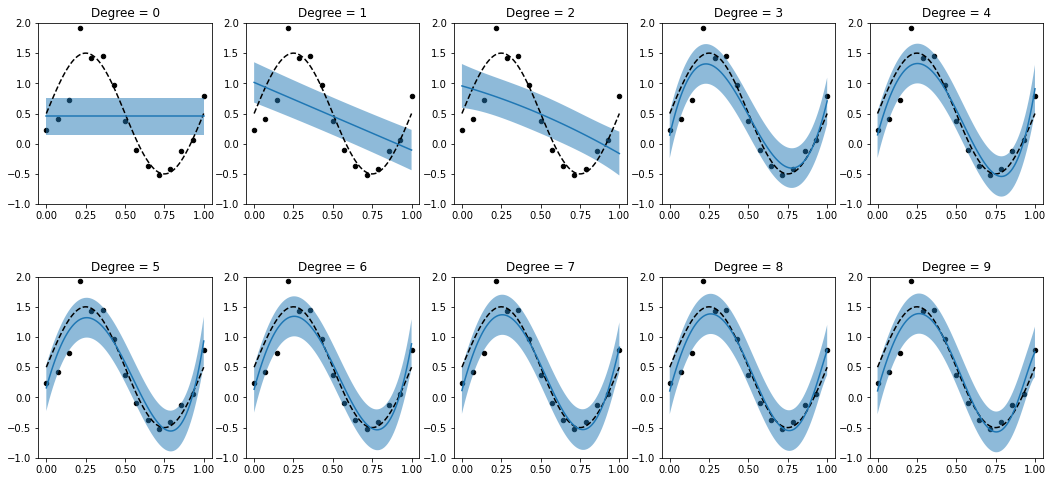

In [15]:
import matplotlib.pyplot as plt

N = 15

beta = 1 / (0.3 ** 2)
alpha = 0.005

degree = 9
degrees = range(degree + 1)

X = np.linspace(0, 1, N).reshape(-1, 1)
t = g(X, noise_variance=1/beta)

Phi = expand(X, bf=polynomial_basis_function, bf_args=degrees[1:])
Phi_test = expand(X_test, bf=polynomial_basis_function, bf_args=degrees[1:])

plt.figure(figsize=(18, 8))
plt.subplots_adjust(hspace=0.4)

for d in degrees:
    up = d + 1
    m_N, S_N = posterior(Phi[:,:up], t, alpha, beta)
    y, y_var = posterior_predictive(Phi_test[:,:up], m_N, S_N, beta)

    plt.subplot(2, 5, up)
    plot_data(X, t)
    plot_truth(X_test, y_true, label=None)
    plot_predictive(X_test, y, np.sqrt(y_var), y_label=None, std_label=None, plot_xy_labels=False)
    plt.title(f'Degree = {d}')
    plt.ylim(-1.0, 2.0)


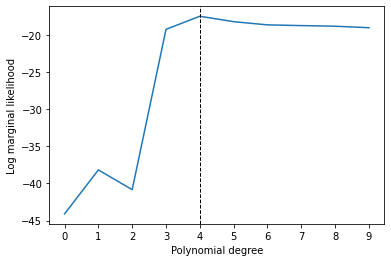

In [16]:
mlls = []

for d in degrees:
    mll = log_marginal_likelihood(Phi[:,:d+1], t, alpha=alpha, beta=beta)
    mlls.append(mll)

degree_max = np.argmax(mlls)
    
plt.plot(degrees, mlls)
plt.axvline(x=degree_max, ls='--', c='k', lw=1)
plt.xticks(range(0, 10))
plt.xlabel('Polynomial degree')
plt.ylabel('Log marginal likelihood');